<a href="https://colab.research.google.com/github/slester87/DeepLearningWithPython/blob/main/DeepLearningWithPythonChapter10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Timeseries Data

This chapter introduced RNN's. We covered simpleRNN, introduced Residual Connections, and then illustrated how LSTM uses operations on the residual connections to achieve Attention. GANs also have attention. Finally, we introduced the Transformer Architecture. Transformer Encoder and Transformer Decoder. The Encoder can do a variety of applications as a standalone one-off operation.


The chapter begins with introducing simpleRNN on the Jena weather dataset

## 10.1 Different kinds of timeseries tasks
A timerseries can be any data obtrained via measurements at regular intervals, such as the daily price of a stock, the hourly electricity consumption of a household or city, or the weekly sales of a business.  Timeseries can be obtained by sensing natural phenomena like wind, temps, seismic activity, game / fish populations, or daily snowfall at Stevens Pass. Human activity accounts for a large quantity of timeseries data, including the hourly number of visitors to a website, a country's GDP, or credit card transactions.  Working with timeseries involves understanding the *dynamics* of a system. So the model we use must be able to learn periodic cycles, trends over time, and regular regime versus anomolous spikes.

The most common of timeseries related tasks is *forecasting*: predict what will happen next: to the price of this stock, how much snow will fall on Stevens Pass in November, how much electricity my home will use on heating this winter. Other tasks are:

*   *Classification* - Assign one ore more categorical labels to a timeseries.  E.g., given timeseries data of a website visitor, determine if this visitor is a human being or a bot.
*   *Event detection* - Identify occurences of specific expected events within a continuous data stream. E.g., Hotword detection "Alexa" "Hey Google"
*   *Anomaly detection* - Detect unusual patterns in a continuous datastream. E.g., Is there a high amount of traffic on the internal network? you could be being hacked. Typically this is done via unsupervised learning.



## 10.2 A temperature-forecasting example
The task at hand is to predict the temperature 24 hours in the future, given a timerseries of hourly measurements of various aspects of weather information.

> *I observe that weather features are highly correlated, so the added dimensions may not necessarily help the model learn as much as independent features might. - Skip*

In [5]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip -d "/content/drive/MyDrive/Colab_Content/jena_climate_2009_2016/"

--2025-06-06 05:56:09--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.226.200, 52.217.137.32, 52.217.193.40, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.226.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  19.4MB/s    in 0.7s    

2025-06-06 05:56:10 (19.4 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: /content/drive/MyDrive/Colab_Content/jena_climate_2009_2016/jena_climate_2009_2016.csv  
  inflating: /content/drive/MyDrive/Colab_Content/jena_climate_2009_2016/__MACOSX/._jena_climate_2009_2016.csv  


#### Listing 10.1 Inspecting the data contained in the Jena weather dataset

In [9]:
import os

root_dir = "/content/drive/MyDrive/Colab_Content/jena_climate_2009_2016/"
fname = os.path.join(root_dir, "jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

for feature in header:
  print(feature)
print(len(lines))

"Date Time"
"p (mbar)"
"T (degC)"
"Tpot (K)"
"Tdew (degC)"
"rh (%)"
"VPmax (mbar)"
"VPact (mbar)"
"VPdef (mbar)"
"sh (g/kg)"
"H2OC (mmol/mol)"
"rho (g/m**3)"
"wv (m/s)"
"max. wv (m/s)"
"wd (deg)"
420451


#### Listing 10.2 Parsing the data

In [13]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

#### Listing 10.3 Plotting the temperature timerseries

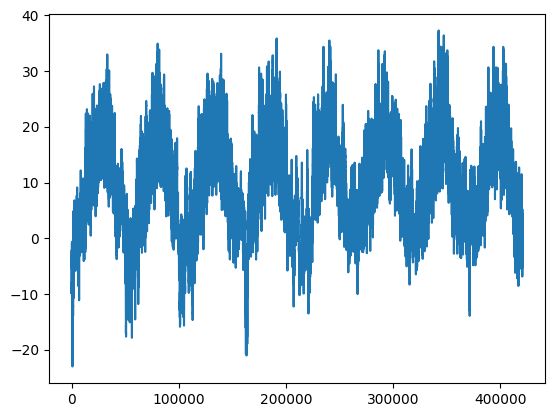

In [12]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

#### Plotting the first ten days of the temperature timeseries

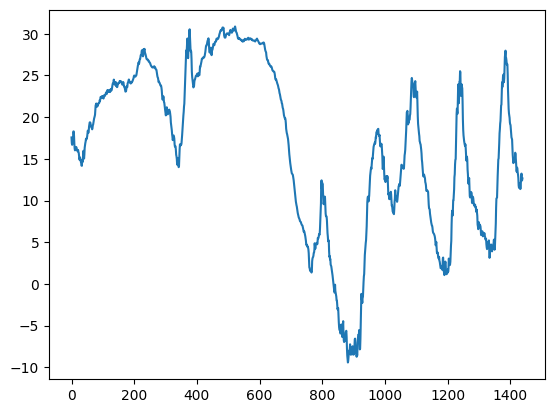

In [16]:
# I'm not working with those silly Canadian numbers :P
def celsius_to_fahrenheit(x):
  return (x * 9/5) + 32

fahrenheit_temps = celsius_to_fahrenheit(temperature[:1440])
plt.plot(range(1440), fahrenheit_temps[:1440])

#### Listing 10.5   Computing the number of samples we'll use for each data split

In [17]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 10.2.0 Problem Statement
Given data covering the previous five days and sampled once per hour, what will the temperature be 24 hours from now?
### 10.2.1 Preparing the data: Normalize it
First, we must normalize the values of each feature so that **they all take small values on a simliar scale** - the requirement for Gradient Descent to work.

#### Listing 10.6 Normalizing the data

In [18]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

We will leverage `timerseries_dataset_from_arrray()` to generate batches of samples from the Jena dataset (rather than munging the entire Jena dataset into memory, which would be wasteful on resources). Furthermore, the dataset features redundant samples... The temperature on day *i* is likely to be similar to the temperature on day *i + 1*, therefor we may sample/downpool the data reduce the memory complexity without losing the overall characteristic of the data.

#### Listing 10.7 Instantiating datasets for training, validation, and testing

In [19]:
import keras

# Observations are taken hourly. We will keep one out of every six observations.
sampling_rate = 6
# The problem statement indicates that we may learn from Observations
# from the last 5 days (120 hours)
sequence_length = 120
# The target for a sequence will be the temperature 24 hours after the end of
# the sequence
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)